In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sys
sys.path.append('..')
import clusterizer

import random
import functools
import operator

%load_ext autoreload
%autoreload 2

Git root path found at: /home/rick/Documents/Universiteit/Wiskunde/Modellenpracticum/SCG-analyse
Using data path:        /home/rick/Documents/Universiteit/Wiskunde/Modellenpracticum/SCG-analyse/data/origineel


In [2]:
#circuitnr = random.choice(clusterizer.globals.available_circuits)
circuitnr = 2079
print(circuitnr)
circuit = clusterizer.circuit.MergedCircuit(circuitnr)
circuit.build()

2079


In [461]:
plt.rcParams['figure.figsize'] = [8, 5]

clusterizer.plot.draw_location_time_scatter(circuit)

In [3]:
all_circuits = set(random.sample(clusterizer.globals.available_circuits, 10))
all_circuits -= {4091}
print(all_circuits)
circuits = [clusterizer.circuit.MergedCircuit(circuitnr) for circuitnr in all_circuits]
for circuit in circuits:
    circuit.build()

{3204, 2981, 3780, 2793, 1465, 2100, 2393, 2779, 3420, 2079}


<IPython.core.display.Javascript object>


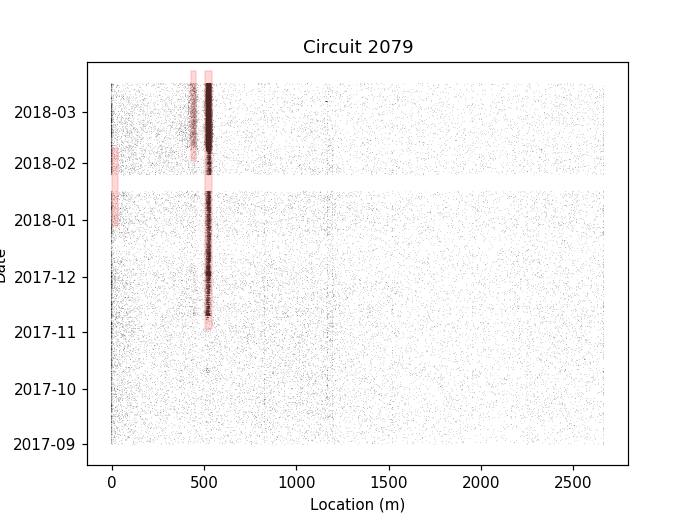

{{0m to 32m; 2017-12-29T00:09:00.000000000 until 2018-02-09T00:09:00.000000000; Found by: Poisson 2D}
{504m to 544m; 2017-11-03T00:09:00.000000000 until 2018-03-23T00:09:00.000000000; Found by: Poisson 2D}
{428m to 456m; 2018-02-02T00:09:00.000000000 until 2018-03-23T00:09:00.000000000; Found by: Poisson 2D}}


In [4]:
%matplotlib notebook

chosen_circuit = list(circuits)[0]
clusters_poisson = clusterizer.algorithms.clusterize_poisson(circuit)
fig, ax = plt.subplots()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax, dot_size_to_charge_ratio=None)
clusterizer.plot.overlay_cluster_ensemble(clusters_poisson, ax=ax)
plt.show()
print(clusters_poisson)

<IPython.core.display.Javascript object>


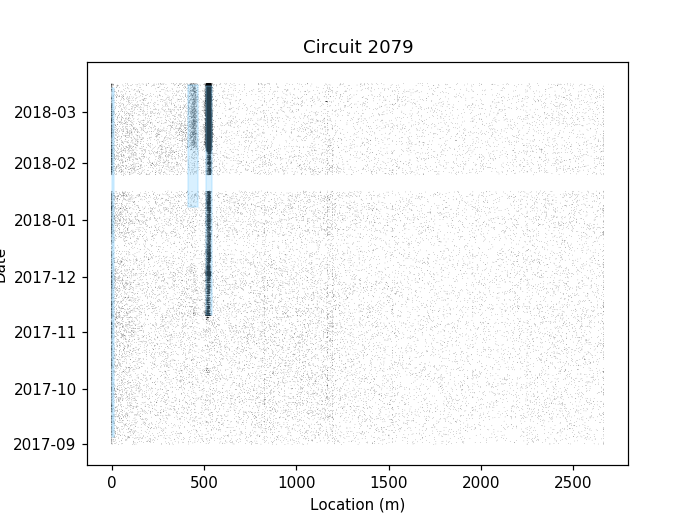

508m to 541m; 2017-11-10T07:31:00.000000 until 2018-03-15T06:12:00.000000; Found by: DBSCAN
0m to 12m; 2017-09-04T22:14:00.000000 until 2018-03-14T04:07:00.000000; Found by: DBSCAN
414m to 467m; 2018-01-08T01:41:00.000000 until 2018-03-15T15:24:00.000000; Found by: DBSCAN


In [5]:
%matplotlib notebook

clusters_DBSCAN = clusterizer.algorithms.clusterize_DBSCAN(circuit)
fig, ax = plt.subplots()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax, dot_size_to_charge_ratio=None)
#clusterizer.plot.overlay_cluster_ensemble(clusters_DBSCAN, ax=ax)
for c in clusters_DBSCAN:
    for r in c:
        print(r)
        clusterizer.plot.overlay_rectangle(r)
plt.show()
#print(clusters_DBSCAN)

<IPython.core.display.Javascript object>


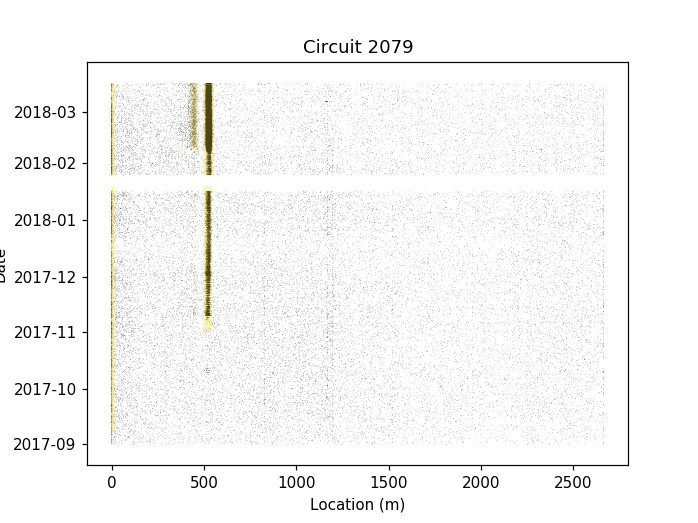

{{0m to 10m; 2018-01-26T00:09:00 until 2018-03-16T00:09:00; Found by: Pinta}
{500m to 540m; 2017-11-03T00:09:00 until 2018-01-19T00:09:00; Found by: Pinta}
{0m to 10m; 2017-09-08T00:09:00 until 2018-01-19T00:09:00; Found by: Pinta}
{430m to 460m; 2018-02-09T00:09:00 until 2018-03-16T00:09:00; Found by: Pinta}
{500m to 550m; 2018-01-26T00:09:00 until 2018-03-16T00:09:00; Found by: Pinta}}


In [6]:
#chosen_circuit = list(circuits)[0]
clusters_pinta = clusterizer.algorithms.clusterize_pinta(circuit)
fig, ax = plt.subplots()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax, dot_size_to_charge_ratio=None)
clusterizer.plot.overlay_cluster_ensemble(clusters_pinta, ax=ax)
plt.show()
print(clusters_pinta)

In [17]:
#%matplotlib notebook


#chosen_circuit = list(circuits)[0]
%timeit

clusterizer.algorithms.clusterize_nothing(circuit)#, choices_exact=300, found_exact=5)
#fig, ax = plt.subplots()
#clusterizer.plot.draw_location_time_scatter(circuit, ax=ax, dot_size_to_charge_ratio=None)
#clusterizer.plot.overlay_cluster_ensemble(clusters_monte_carlo, ax=ax)
#plt.show()
#print(clusters_monte_carlo)

}

# ClusterEnsemble

Een ClusterEnsemble is een set van ClusterSet objecten. Een ClusterSet is een set van Cluster objecten. Deze gestapelde structuur zorgt ervoor dat clusters die bij elkaar horen in dezelfde ClusterSet worden gestopt, en verschillende clusters gescheiden blijven.
Door twee clusters bij elkaar op te tellen met + kun je de resultaten van meerdere algoritmes combineren.

## Runtime
Op circuit 2063

| Algorithms             | Combine | Runtime          |
|------------------------|---------|------------------|
| Poisson, DBSCAN        | &       | 231 ms ± 9.26 ms |
| Poisson, pinta         | &       | 986 ms ± 14.1 ms |
| DBSCAN, pinta          | &       | 1.1 s ± 31 ms    |
| Poisson, DBSCAN, pinta | &       | 1.15 s ± 25.7 ms |
| Poisson, DBSCAN        | \|      | 232 ms ± 6.89 ms |
| Poisson, pinta         | \|      | 1.01 s ± 13.4 ms |
| DBSCAN, pinta          | \|      | 1.11 s ± 14.6 ms |
| Poisson, DBSCAN, pinta | \|      | 1.13 s ± 20.1 ms |
| Poisson, DBSCAN        | +       | 235 ms ± 7.53 ms |
| Poisson, pinta         | +       | 987 ms ± 17.2 ms |
| DBSCAN, pinta          | +       | 1.1 s ± 10.4 ms  |
| Poisson, DBSCAN, pinta | +       | 1.18 s ± 25.5 ms |


| Algorithms | Runtime           |
|------------|-------------------|
| Poisson    | 49.1 ms ± 1.46 ms |
| DBSCAN     | 173 ms ± 1.62 ms  |
| pinta      | 924 ms ± 11.3 ms  |

| Combine | Runtime           |
|---------|-------------------|
| &       | 909 µs ± 20 µs    |
| \|      | 6.46 ms ± 138 µs  |
| +       | 82.8 ms ± 2.31 ms |

In [28]:
from clusterizer.algorithms import clusterize_poisson, clusterize_DBSCAN, clusterize_pinta, clusterize_Monte_Carlo, clusterize_ensemble

In [74]:
%%timeit
algorithms = clusterize_pinta,
ensemble = clusterize_ensemble(circuit, algorithms=algorithms, combine="add")

924 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
%%timeit

combined = clusters_poisson + clusters_DBSCAN + clusters_pinta

82.8 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


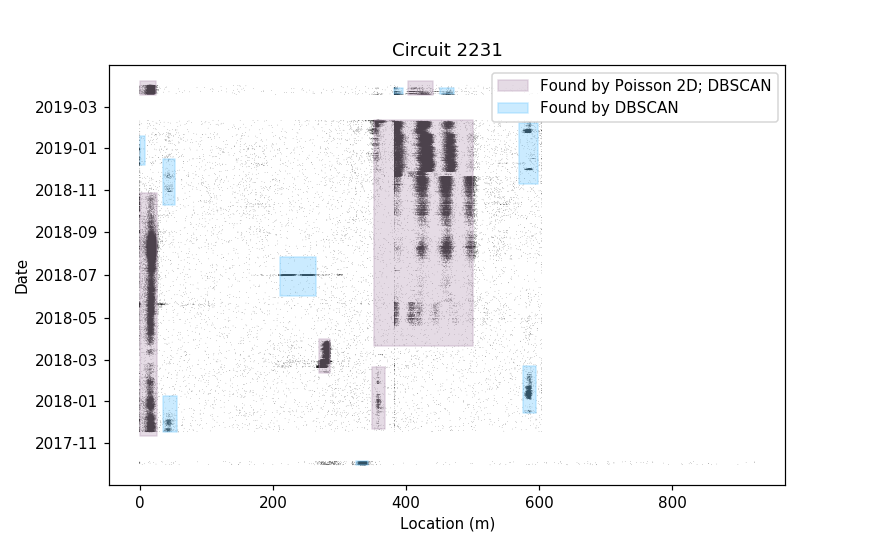

In [49]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [8, 5]

ax = plt.gca()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax, dot_size_to_charge_ratio=None)
clusterizer.plot.overlay_cluster_ensemble(ensemble, opacity=.4, scale_opacity_by_found_by_count=False)
clusterizer.plot.legend_without_duplicate_labels()
plt.show()

### clusterize_ensemble

Door algoritmes mee te geven aan clusterize_ensemble kun je in 1 keer meerdere algoritmes toepassen op een circuit. De resultaten van de algoritmes worden gecombineerd in een ClusterEnsemble.

In [467]:
poisson_different_param = lambda circuit: clusterizer.algorithms.clusterize_poisson(circuit, certainty=.99999, name="Strict")
algorithms = [poisson_different_param, clusterizer.algorithms.clusterize_poisson, clusterizer.algorithms.clusterize_DBSCAN]
ensemble_combined = clusterizer.algorithms.clusterize_ensemble(circuit, algorithms)
print(ensemble_combined)

AttributeError: module 'clusterizer.algorithms' has no attribute 'clusterize_ensemble'

In [ ]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [8, 5]

clusters_poisson_e = [c for c in ensemble_combined.get_clusters() if c.found_by == {"Poisson 2D"}]
clusters_poisson_strict = [c for c in ensemble_combined.get_clusters() if c.found_by >= {"Strict"} and "DBSCAN" not in c.found_by]
clusters_DBSCAN_e = [c for c in ensemble_combined.get_clusters() if c.found_by == {"DBSCAN"}]
clusters_all = [c for c in ensemble_combined.get_clusters() if len(c.found_by) > 2]
clusters_poisson_DBSCAN = [c for c in ensemble_combined.get_clusters() if c.found_by == {"Poisson 2D", "DBSCAN"}]

ax = plt.gca()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_poisson_e, color="Red", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_DBSCAN_e, color="Blue", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_poisson_strict, color="#FFA71A", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_poisson_DBSCAN, color="Purple", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_both, color="Green", ax=ax)

plt.show()

In [ ]:
%matplotlib notebook

one_cluster = ensemble_combined.as_list()[0]

bounding_box = one_cluster.as_list()[0]
for c in one_cluster:
    bounding_box |= c

plt.cla()
ax = plt.gca()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax)
clusterizer.plot.overlay_cluster_collection([bounding_box], color="Red", ax=ax)

# Tijdsanalyze van Monte Carlo clustering

locations and times laden: 2.49 ms ± 34.1 µs

time_factor: 97.3 ms ± 1.82 ms

num: 679 ns ± 10.6 ns

chosen_pds, locations, times: 242 µs ± 10.6 µs

rectangle-ize: 25.8 µs ± 400 ns

cluster-ize: 4.87 µs ± 84.2 ns

reduce: 17.1 µs ± 264 ns

highly_found: 1.6 µs ± 10 ns

change found_by: 169 ns ± 1.71 ns

#### total execution time in actual call to clusterize_Monte_Carlo: 367 ms ± 17 ms


Conclusie: time_factor berekenen duurt absurd lang

Aanpassingen:

min(times) -> times[times.index[0]]

max(times) -> times[times.index[-1]]

time_factor new: 74.6 µs ± 2.08 µs

#### total execution time in actual call to clusterize_Monte_Carlo: 277 ms ± 12.6 ms

<IPython.core.display.Javascript object>


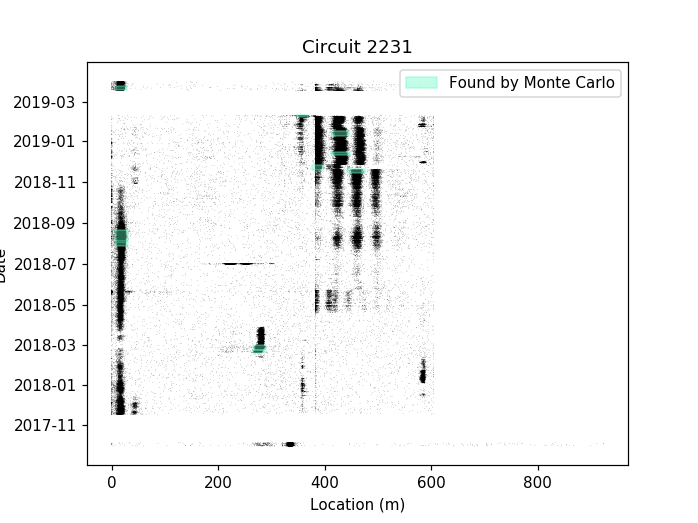

In [9]:
%matplotlib notebook
random_ensemble = clusterizer.algorithms.clusterize_Monte_Carlo(circuit, choices_exact=300, found_exact=5)
fig, ax = plt.subplots()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax, dot_size_to_charge_ratio=None)
clusterizer.plot.overlay_cluster_ensemble(random_ensemble, opacity=.4, scale_opacity_by_found_by_count=False)
clusterizer.plot.legend_without_duplicate_labels()

In [139]:
locations = circuit.pd["Location in meters (m)"][circuit.pd_occured]
times = circuit.pd["Date/time (UTC)"][circuit.pd_occured]
    
time_factor = (times[times.index[-1]] - times[times.index[0]]) / np.timedelta64(30, 'D')
num = int(circuit.circuitlength * time_factor)
chosen_pds = np.random.randint(len(locations), size=num // choices_div)
chosen_locations = locations.iloc[chosen_pds].values
chosen_times = times.iloc[chosen_pds].values

In [158]:
from clusterizer.rectangle import Rectangle
from clusterizer.cluster import Cluster
from clusterizer.ensemble import ClusterEnsemble

loc_rect_size = 32
time_rect_size = np.timedelta64(6, 'D')
xlength = loc_rect_size // 2
ylength = time_rect_size // 2    
rectangles = set()
for i, point in enumerate(zip(chosen_locations, chosen_times)):
    rectangles.add(Rectangle(location_range=(point[0]-xlength/2, point[0]+xlength/2), time_range=(point[1]-ylength/2, point[1]+ylength/2), found_by={str(i)}))
clusters = {ClusterEnsemble({Cluster({r})}) for r in rectangles}
reduced = functools.reduce(operator.__or__, clusters)
highly_found = [x for x in reduced if len(x.found_by) > num // (100*50)]
result = set()
for c in highly_found:
    for r in c:
        r.found_by = {"Monte Carlo"}

<IPython.core.display.Javascript object>


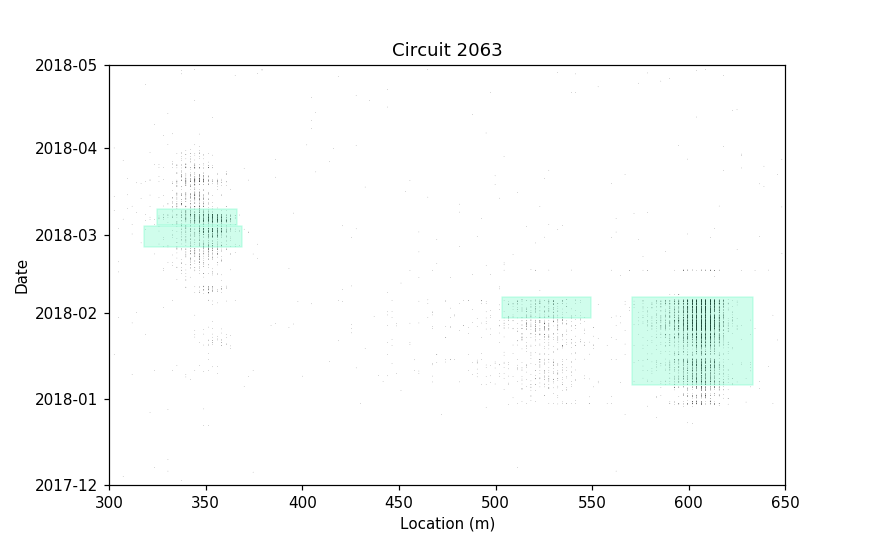

Saved to /notebooks/Zoomed_in_Monte_Carlo.png


In [171]:
fig, ax = plt.subplots()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax, dot_size_to_charge_ratio=None)
#ax.scatter(x=chosen_locations, y=chosen_times, s=0.3, c="#64fbc3ff", label="", marker='8', edgecolors="none")
clusterizer.plot.overlay_cluster_ensemble([c for c in highly_found])
ax.set_xlim([300, 650])
ax.set_ylim([np.datetime64("2017-12"), np.datetime64("2018-05")])
ax.tick_params(axis='y', which='major')
clusterizer.plot.save_figure_for_google_slides("Zoomed_in_Monte_Carlo")